# Tutorial 6. Dissecting Time Series and Sequential Data

In this notebook we will cover the following:

1. [Transforming data into time series format](#timeseries)
2. [Slicing time series](#slicing)
3. [Operating on time series data](#operating)
4. [Extracting statistics from time series data](#stats)
5. [Building Hidden Markov Models for sequential data](#markov)
6. [Building Conditional Random Fields for sequential text data](#conditional)
7. [Analyzing stock market data using Hidden Markov Models](#stock)

Time series data are measurements taken with respect to a predetermined variable and at regular time intervals, where ordering matters. Sequential data is a generalized notion that emcompasses any data that comes in sequential form, including time series data.

We will build models that describe the pattern of the time series or any sequence in general. We can use these models to explain how the past might affect the future and see how two datasets can be correlated to forecast future values. Time series analysis is used in finance, signal-processing, weather prediction, or any field where we have temporal data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

## 6.1 Transforming data into time series format <a class="anchor" id="timeseries"></a>

As in the previous notebooks, pandas is extremely helpful here for time series analysis. Here we will use the included file *data_timeseries.txt*.

In [2]:
data = pd.read_csv('data_timeseries.txt',names=['year','month','x1','x2'])
data.head()

,year,month,x1,x2
0,1940,1,98.96,64.81
1,1940,2,10.89,71.38
2,1940,3,6.22,14.39
3,1940,4,67.85,99.24
4,1940,5,31.70,5.09


Let's make the index dates, using the code below, and then we can remove year and month:

In [3]:
data.index= pd.to_datetime({'year':data.year,'month':data.month,'day':1})
data = data.to_period('M') # No days so we only need months
data = data.drop(['year','month'],axis=1)
data.head()

,x1,x2
1940-01,98.96,64.81
1940-02,10.89,71.38
1940-03,6.22,14.39
1940-04,67.85,99.24
1940-05,31.70,5.09


Plot the time series using Pandas built in plotting:

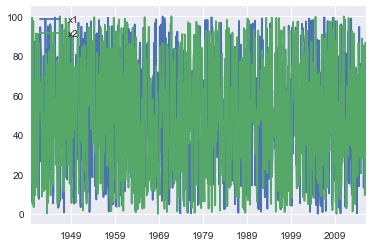

In [4]:
data.plot()

You can see from the above it looks very messy since there is such a large amount of data plotted for both.

## 6.2 Slicing time series data <a class="anchor" id="slicing"></a>

We will use the example in the last section to learn how to slice particular date ranges.

Using the dates as index makes it especially easy to slice:

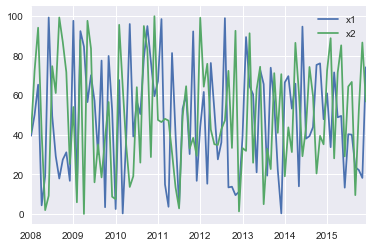

In [5]:
start = '2008' #start year
end   = '2015' #end year
slicedata = data.loc[start:end]
slicedata.plot()

Try another slicing of dates:

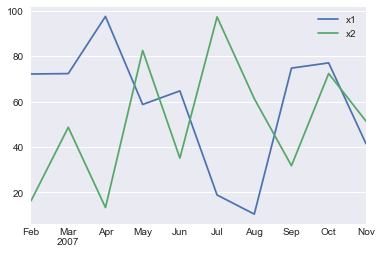

In [6]:
start = '2007-02' #start year
end   = '2007-11' #end year
slicedata2 = data.loc[start:end]
slicedata2.plot()

## 6.3 Operating on time series data <a class="anchor" id="operating"></a>

Pandas library allows for many ways to operate and filter data. We will use the same data from the first section.

#### Plotting operation on dataset

Taking differences

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


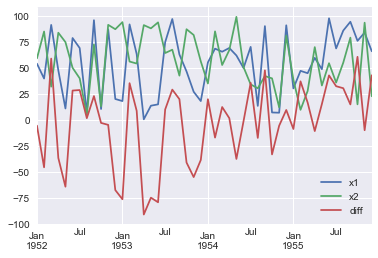

In [7]:
datac = data.copy()
difference = datac.loc['1952':'1955',:]
difference['diff'] = difference.x1 - difference.x2
difference.plot()

Filtering based on conditions of columns:

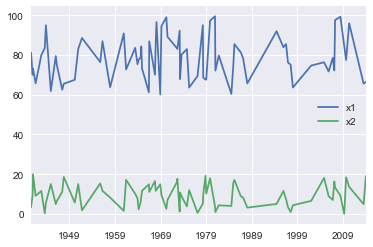

In [8]:
datac[(datac.x1>60) & (datac.x2<20)].plot()

## 6.4 Extracting statistics from time series data <a class="anchor" id="stats"></a>

An important reason for analyzing time series data is to extract statistics from it. We will look at a few here using the same text file we used in previous sections.

Minimum and maximum values:

In [9]:
print('Maximum\n', data.max() )
print('Minimum\n', data.min() )

Maximum
 x1    99.82
x2    99.97
dtype: float64
Minimum
 x1    0.07
x2    0.00
dtype: float64


Mean values:

In [10]:
print('Mean\n',data.mean())
print('Mean row-wise\n', data.mean(1)[:10])

Mean
 x1    51.264529
x2    49.695417
dtype: float64
Mean row-wise
 1940-01    81.885
1940-02    41.135
1940-03    10.305
1940-04    83.545
1940-05    18.395
1940-06    16.695
1940-07    86.875
1940-08    42.255
1940-09    55.880
1940-10    34.720
Freq: M, dtype: float64


Pandas also has a handy call for quick description of dataframes, where we can see mean, std, and percentiles:

In [11]:
data.describe()

,x1,x2
count,912.000000,912.000000
mean,51.264529,49.695417
std,29.086753,28.785874
min,0.070000,0.000000
25%,25.410000,25.322500
50%,52.520000,48.015000
75%,76.532500,74.420000
max,99.820000,99.970000


Rollling mean is an important statistic used in time series analysis, used to smooth a signal to remove higher frequency noise. There is a window of length *N* that we slide on the time series:

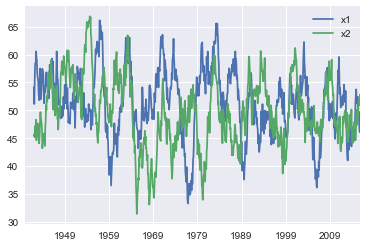

In [12]:
# Plot rolling mean
data.rolling(window=24).mean().plot()

Can compare the above to the first one we plotted and we can see more than just noise.

Let's look at correlation coefficients:

In [13]:
#Correlation coefficients
print('Correlation coefficients\n',data.corr())

Correlation coefficients
           x1        x2
x1  1.000000  0.077607
x2  0.077607  1.000000


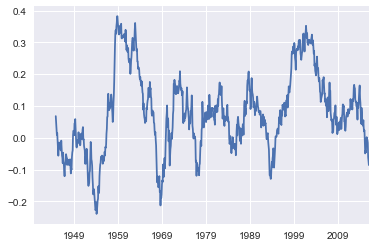

In [14]:
# Plot rolling correlation coefficients
#pd.rolling_corr(data.x1,data.x2,window=60).plot() #deprecated
data['x1'].rolling(window=60).corr(data['x2']).plot()


## 6.5 Building Hidden Markov Models for sequential data <a class="anchor" id="markov"></a>

The **Hidden Markov Models (HMMs)** are extensively used for sequential data analysis in finance, speech analysis, weather forecasting, etc where we are interested in hidden patterns that appear over time.

**HMMs** are generative models, which means that they can generate the data once they learn the underlying structure. This is in contrast to discriminative models that can learn to discriminate between classes but cannot generate data.

In a HMM, the state is not directly visible, but the output, dependent on the state, is visible. Each state has a probability distribution over the possible output tokens. Therefore, the sequence of tokens generated by an HMM gives some information about the sequence of states. The adjective 'hidden' refers to the state sequence through which the model passes, not to the parameters of the model; the model is still referred to as a 'hidden' Markov model even if these parameters are known exactly.

For example, suppose we want to predict whether the weather will be sunny, chilly or rainy tomorrow. We can look at all the weather parameters such as temperature, pressure, humidity, etc. whereas the underlying state is hidden. Here, the underlying state refers to 3 options: sunny, chilly or rainy. 

We will use the **hhmlearn** python package for this section (available here: https://github.com/hmmlearn/hmmlearn), and the *data_hmm.txt* file provided.

In [15]:
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings('ignore') #hmm module has many warnings since deprecated from sklearn

data = pd.read_csv('data_hmm.txt',names=['year','month','x'])
data.head()

,year,month,x
0,1740,1,0.14
1,1740,2,0.14
2,1740,3,0.03
3,1740,4,0.07
4,1740,5,0.09


Conver to datetime index like we did earlier:

In [16]:
data.index= pd.to_datetime({'year':data.year,'month':data.month,'day':1})
data = data.to_period('M') # No days so we only need months
data = data.drop(['year','month'],axis=1)
display( data.head() )
data.describe()

,x
1740-01,0.14
1740-02,0.14
1740-03,0.03
1740-04,0.07
1740-05,0.09


,x
count,3312.000000
mean,4.557585
std,2.868680
min,0.000000
25%,2.100000
50%,4.185000
75%,7.090000
max,9.200000


#### Make some quick plots of data

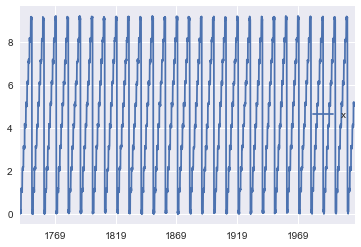

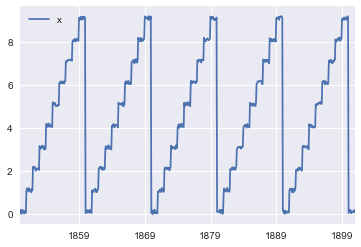

In [17]:
data.plot()
data.loc['1850':'1900'].plot()

Can see there is a step-like structure with a period of 10years present in the data.

#### Create and train an HMM

The number of components is a hyperparameter that we have to choose. Here by selecting 4, we're saying thatt we think there are 4 underyling states. We will vary this parameter later.

In [18]:
X = data.x
#Create Gaussian HMM
num_components=4
model = GaussianHMM(n_components=num_components,covariance_type='diag',n_iter=1000)
model.fit(X.reshape(-1,1))

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

Run the predictor to get the hidden states:

In [19]:
hidden_states = model.predict(X.reshape(-1,1))

Compute mean and variance of the hidden states:

In [20]:
for i in range(model.n_components):
    print('Hidden state,',i+1)
    print('...Mean     =',round(model.means_[i][0],3))
    print('...Variance =',round(np.diag(model.covars_[i])[0],3))

Hidden state, 1
...Mean     = 0.6
...Variance = 0.254
Hidden state, 2
...Mean     = 8.099
...Variance = 0.678
Hidden state, 3
...Mean     = 2.601
...Variance = 0.257
Hidden state, 4
...Mean     = 5.092
...Variance = 0.677


Since HHMs are generative we can generate samples, for example 1000 of them and make a plot:

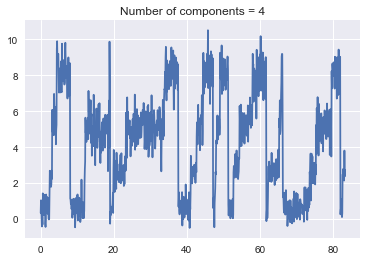

In [21]:
n_samples=1000
samples,_ = model.sample(n_samples)
plt.plot(np.arange(n_samples)/12.,samples[:,0])
plt.title('Number of components = '+ str(num_components))

If you increase the number of components you can see the curve gets nicer as you are giving more freedom to train and allowing larger number of hidden states. Below we will try with 12.

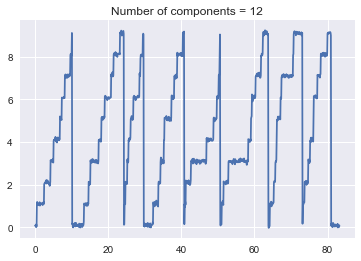

In [22]:
#Create Gaussian HMM
num_components=12
model = GaussianHMM(n_components=num_components,covariance_type='diag',n_iter=1000)
model.fit(X.reshape(-1,1))
n_samples=1000
samples,_ = model.sample(n_samples)
plt.plot(np.arange(n_samples)/12.,samples[:,0])
plt.title('Number of components = '+ str(num_components))

We can see that with 12 components above it looks more like the earlier plot. 

## 6.6 Analyzing stock market data using Hidden Markov Models <a class="anchor" id="stock"></a>

We will use the stock market data we had in Tutorial 4 here again. We will see how the stock values of various companies fluctuate over time. 

Here we'll only look at a single company, Intel Corporation (INTC) and dates from 1994-4-5 to 2015-7-3.

In [23]:
import datetime
from matplotlib.finance import quotes_historical_yahoo_ochl as quotes_yahoo

In [24]:
start_date = datetime.datetime(1994,4,5)
end_date   = datetime.datetime(2015,7,3)

quotes = quotes_yahoo('INTC',start_date,end_date,asobject=True)
# Make index for dataframe from datetimes
datetimeindex = pd.DatetimeIndex(quotes['date'])
stockDF = pd.DataFrame({'open':quotes['open'],'close':quotes['close'],'volume':quotes['volume']},
                        index=datetimeindex)
stockDF.head()

,close,open,volume
1994-04-05,2.931300,2.920641,80224000.0
1994-04-06,2.968607,2.952618,53240000.0
1994-04-07,3.011244,2.973937,42585600.0
1994-04-08,2.957948,3.005915,51513600.0
1994-04-11,2.949953,2.909981,38897600.0


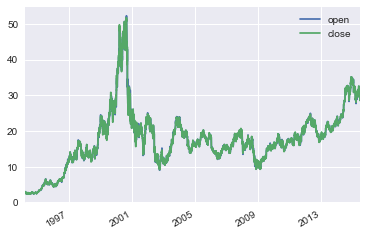

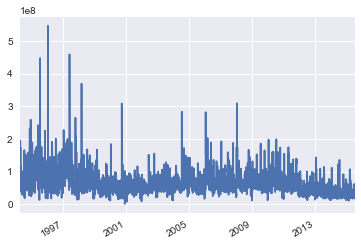

In [25]:
stockDF[['open','close']].plot()
plt.figure()
stockDF.volume.plot()

We'll now create a new feature which is the percent rate of change of the closing values of the stock.

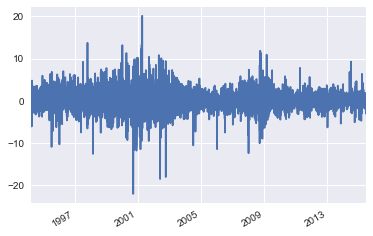

In [26]:
closerateDF =  pd.DataFrame(index=stockDF.index[1:])
closerateDF['volume'] = stockDF.volume[1:]
closerateDF['close%'] = 100.*np.diff(stockDF.close.values)/stockDF.close.values[:-1]
closerateDF['close%'].plot()

Will use percentage closing change and volume for training.

#### Build HMM model

In [27]:
model = GaussianHMM(n_components=5,covariance_type='diag',n_iter=1000)
model.fit(closerateDF)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=5, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

Generate 500 samples using HMM and plot:

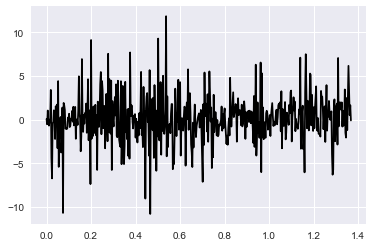

In [28]:
n_samples = 500
samples,_ = model.sample(n_samples)
plt.plot(np.arange(n_samples)/365,samples[:,1],c='k')

We can compare the above to the previous plot and see that the mean and variance is roughly captured by the HMM.